In [1]:
import random as random
import Bio
import numpy as np
import sys
import os
import networkx as nx
import random as random
from tqdm import tqdm # loading bar
from utils_copy import linear_C, get_cost_2, get_sequence_string, parse_fasta_multiple, create_score_matrix, write_alignments_to_file, linear_backtrack, fill_graph,new_sp_approxi_combi
from utils_copy import convert_to_desired_format_nr_version, compute_cost, my_traversal_simply, extend_alignment_chaos, find_min_span_edges_testing, parse_fasta_multiple_remove_n
import timeit
from utils_copy import al_integrity_testt
from old_for_testing.sp_approx import sp_approx
from old_for_testing.utils import *
from functions_multiple_version import *
import matplotlib.pyplot as plt

score_matrix={'a': {'a': 0, 'c': 5, 'g': 2, 't': 5}, 'c': {'a': 5, 'c': 0, 'g': 5, 't': 2}, 'g': {'a': 2, 'c': 5, 'g': 0, 't': 5}, 't': {'a': 5, 'c': 2, 'g': 5, 't': 0}}
gap_cost=5



In [2]:
def make_related_strings(nr_of_str:int,len_of_str, degree_of_variation:float, start_string):
    string_fam_collection=[]
    first_string=[]
    if start_string==False:
        for k in range(0,random.randrange((len_of_str-1),len_of_str+5)):
                first_string.append(random.choice(['a','c','t','g']))
        first_string=''.join(first_string)
        string_fam_collection.append(first_string)
    else:
         first_string=start_string
         string_fam_collection.append(first_string)

    for i in range(1,nr_of_str):
        a_sequence=[]
        for element in first_string:
            if random.random() < degree_of_variation: #checking if we should change the charachter
                a_sequence.append(random.choice(['a','c','t','g']))
            else:
                 a_sequence.append(element)
        a_sequence=''.join(a_sequence)
        string_fam_collection.append(a_sequence)
    return string_fam_collection

#make_related_strings(3,12,0.1,False)


def make_strings_in_families(nr_of_fams, nr_str_pr_fam, len_of_str, internal_var_in_fams, degree_of_var_from_first_fam):
    all_strings_coll = []
    first_family = make_related_strings(nr_str_pr_fam, len_of_str, internal_var_in_fams[0], start_string=False)
    all_strings_coll.append(first_family)
    
    for i in range(1, nr_of_fams):
        carry_over_string = first_family[0]
        mutated_carry_over = []
        for element in carry_over_string:
            if random.random() < degree_of_var_from_first_fam[i]:  # checking if we should change the character
                mutated_carry_over.append(random.choice(['a', 'c', 't', 'g']))
            else:
                mutated_carry_over.append(element)
        mutated_carry_over = ''.join(mutated_carry_over)  # Join the list of characters into a string
        family = make_related_strings(nr_str_pr_fam, len_of_str, internal_var_in_fams[i],mutated_carry_over)
        all_strings_coll.append(family)
    return all_strings_coll

make_strings_in_families(3, 2, 15, [0.1, 0.1,0.1], [0, 0.9,0.5])


[['agttactccaggagaaaa', 'agttactccaggagaaaa'],
 ['agttgatctgtagaaatg', 'acttgatctgtagaaatg'],
 ['tagtaattgaggagtaat', 'tagtaattgaggagtaat']]

In [14]:
random_sequences_collection=[]
for i in range(0,100):
    random_pile=[]
    for j in range (0,10):
        a_sequence=[]
        for k in range(0,random.randrange(4,10)):
            a_sequence.append(random.choice(['a','c','t','g']))
        a_sequence=''.join(a_sequence)
        random_pile.append(a_sequence)

    random_sequences_collection.append(random_pile)

#print(random_sequences_collection)


big_collection_in_families=[]
for x in range(0,20):
    random_sequences_collection_in_fams=make_strings_in_families(3, 5, 15, [0.1, 0.1,0.1], [0, 0.9,0.5])
    random_sequences_collection_in_fams = [string for sublist in random_sequences_collection_in_fams for string in sublist]
    big_collection_in_families.append(random_sequences_collection_in_fams)
print(big_collection_in_families)

[['gccgaggcacgcag', 'gccgaggcacgcag', 'gccgaggcaggcag', 'gacgtggcacgcag', 'tccgaggcacgctg', 'cgcagacggattaa', 'ggcagacggattaa', 'cgaagacggattaa', 'cgcagacggattta', 'cgcagacggatcaa', 'tctgaggaatacag', 'tctgaggaatacag', 'cctgaggattacag', 'tctgaagaagactg', 'tctgaggaatacag'], ['tggcctaccgtcct', 'tggcctaccgtcct', 'tggcctaccgtcct', 'tggcctaccgtccc', 'aggcctactgtcct', 'gcctcgcgccaaga', 'gcctcgcgccaaga', 'gcctcgagccaaga', 'acctcgtgccagga', 'gcctcgcgaccaga', 'tggccggccgcacg', 'tggccggtcgcacg', 'tggcccgccgcacc', 'tggccggcggcacg', 'tggccggtcgcacg'], ['aagaatgcacggatgg', 'aagaatggacgcatga', 'aagaatgcacgcctgg', 'aagaatgcacggatgg', 'aagaatggacttatgg', 'cacgagggaagtttgg', 'catgagggaagtttgg', 'cacgagggaagtttgg', 'cacgagtgaagtatga', 'cacgagggaggtttgg', 'aagagcggtcgatagt', 'aagagcggtcgatagt', 'aagagcggtcgatagt', 'aattgcggtcgatagt', 'aagagcggtcgatagt'], ['tacatttacgagagatac', 'tccgattacgagagatac', 'tacatttacgagagatac', 'tacatttaccagagatac', 'tacctttacgagagatac', 'ccttgggcatccatagcc', 'ccttggggatccatagcc'

Here comes the distance matrix produced by the alignments: 

[[ 0.  0.  5. 10. 10. 31. 30. 32. 34. 29. 16. 16. 21. 26. 16.]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan

Here comes the distance matrix produced by the alignments: 

[[ 0.  0.  5. 10. 10. 31. 30. 32. 34. 29. 16. 16. 21. 26. 16.]
 [ 0.  0.  5. 10. 10. 31. 30. 32. 34. 29. 16. 16. 21. 26. 16.]
 [ 5.  5.  0. 15. 15. 30. 25. 27. 35. 28. 19. 19. 24. 21. 19.]
 [10. 10. 15.  0. 20. 34. 29. 33. 38. 32. 26. 26. 31. 36. 26.]
 [10. 10. 15. 20.  0. 32. 35. 32. 32. 34. 16. 16. 23. 16. 16.]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan

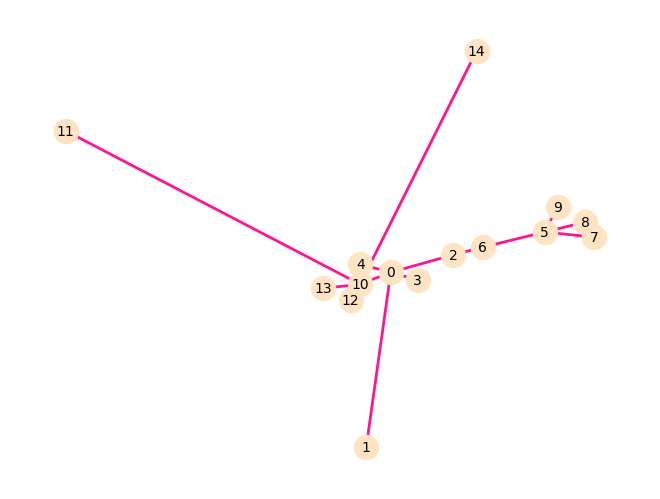

this is A_dict: 
{'0_3': [['g', 'g'], ['a', 'c'], ['c', 'c'], ['g', 'g'], ['t', 'a'], ['g', 'g'], ['g', 'g'], ['c', 'c'], ['a', 'a'], ['c', 'c'], ['g', 'g'], ['c', 'c'], ['a', 'a'], ['g', 'g']], '0_1': [['g', 'g'], ['c', 'c'], ['c', 'c'], ['g', 'g'], ['a', 'a'], ['g', 'g'], ['g', 'g'], ['c', 'c'], ['a', 'a'], ['c', 'c'], ['g', 'g'], ['c', 'c'], ['a', 'a'], ['g', 'g']], '0_2': [['g', 'g'], ['c', 'c'], ['c', 'c'], ['g', 'g'], ['a', 'a'], ['g', 'g'], ['g', 'g'], ['c', 'c'], ['a', 'a'], ['c', 'g'], ['g', 'g'], ['c', 'c'], ['a', 'a'], ['g', 'g']], '0_4': [['g', 't'], ['c', 'c'], ['c', 'c'], ['g', 'g'], ['a', 'a'], ['g', 'g'], ['g', 'g'], ['c', 'c'], ['a', 'a'], ['c', 'c'], ['g', 'g'], ['c', 'c'], ['a', 't'], ['g', 'g']], '0_10': [['g', 't'], ['c', 'c'], ['c', 't'], ['g', 'g'], ['a', 'a'], ['g', 'g'], ['g', 'g'], ['c', 'a'], ['a', 'a'], ['c', 't'], ['g', 'a'], ['c', 'c'], ['a', 'a'], ['g', 'g']], '2_6': [['g', 'g'], ['c', 'g'], ['c', 'c'], ['g', '-'], ['a', 'a'], ['g', 'g'], ['g', 'a'], ['c'

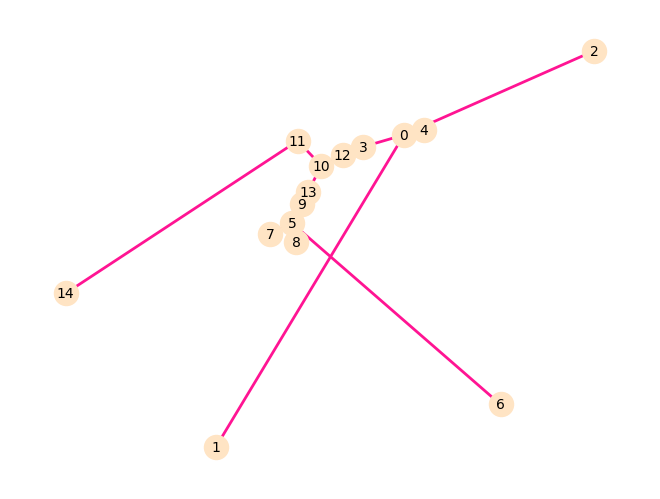

this is A_dict: 
{'0_4': [['a', 't'], ['g', 'g'], ['g', 'g'], ['c', 'c'], ['c', 'c'], ['t', 't'], ['a', 'a'], ['c', 'c'], ['t', 'c'], ['g', 'g'], ['t', 't'], ['c', 'c'], ['c', 'c'], ['t', 't']], '0_1': [['t', 't'], ['g', 'g'], ['g', 'g'], ['c', 'c'], ['c', 'c'], ['t', 't'], ['a', 'a'], ['c', 'c'], ['c', 'c'], ['g', 'g'], ['t', 't'], ['c', 'c'], ['c', 'c'], ['t', 't']], '0_2': [['t', 't'], ['g', 'g'], ['g', 'g'], ['c', 'c'], ['c', 'c'], ['t', 't'], ['a', 'a'], ['c', 'c'], ['c', 'c'], ['g', 'g'], ['t', 't'], ['c', 'c'], ['c', 'c'], ['t', 't']], '0_3': [['t', 't'], ['g', 'g'], ['g', 'g'], ['c', 'c'], ['c', 'c'], ['t', 't'], ['a', 'a'], ['c', 'c'], ['c', 'c'], ['g', 'g'], ['t', 't'], ['c', 'c'], ['c', 'c'], ['t', 'c']], '3_12': [['t', 't'], ['g', 'g'], ['g', 'g'], ['c', 'c'], ['c', 'c'], ['t', 'c'], ['a', 'g'], ['c', 'c'], ['c', 'c'], ['g', 'g'], ['t', 'c'], ['c', 'a'], ['c', 'c'], ['c', 'c']], '10_12': [['t', 't'], ['g', 'g'], ['g', 'g'], ['c', 'c'], ['c', 'c'], ['c', 'g'], ['g', 'g'], ['

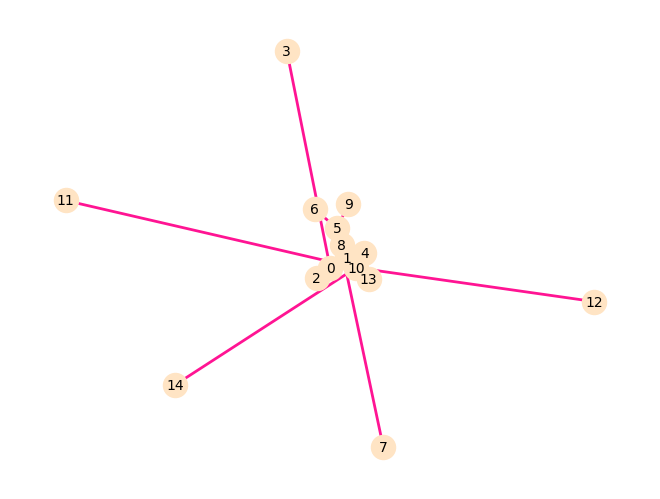

this is A_dict: 
{'5_7': [['c', 'c'], ['a', 'a'], ['c', 'c'], ['g', 'g'], ['a', 'a'], ['g', 'g'], ['g', 'g'], ['g', 'g'], ['a', 'a'], ['a', 'a'], ['g', 'g'], ['t', 't'], ['t', 't'], ['t', 't'], ['g', 'g'], ['g', 'g']], '5_6': [['c', 'c'], ['a', 'a'], ['c', 't'], ['g', 'g'], ['a', 'a'], ['g', 'g'], ['g', 'g'], ['g', 'g'], ['a', 'a'], ['a', 'a'], ['g', 'g'], ['t', 't'], ['t', 't'], ['t', 't'], ['g', 'g'], ['g', 'g']], '5_9': [['c', 'c'], ['a', 'a'], ['c', 'c'], ['g', 'g'], ['a', 'a'], ['g', 'g'], ['g', 'g'], ['g', 'g'], ['a', 'a'], ['a', 'g'], ['g', 'g'], ['t', 't'], ['t', 't'], ['t', 't'], ['g', 'g'], ['g', 'g']], '5_8': [['c', 'c'], ['a', 'a'], ['c', 'c'], ['g', 'g'], ['a', 'a'], ['g', 'g'], ['g', 't'], ['g', 'g'], ['a', 'a'], ['a', 'a'], ['g', 'g'], ['t', 't'], ['t', 'a'], ['t', 't'], ['g', 'g'], ['g', 'a']], '1_8': [['c', '-'], ['a', 'a'], ['c', 'a'], ['g', 'g'], ['a', 'a'], ['g', 'a'], ['t', 't'], ['g', 'g'], ['a', 'g'], ['a', 'a'], ['-', 'c'], ['g', 'g'], ['t', 'c'], ['a', 'a'], ['

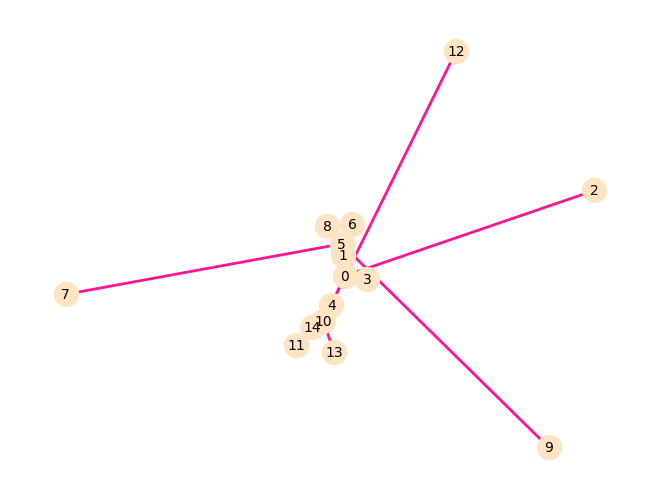

this is A_dict: 
{'5_7': [['c', 'c'], ['c', 'c'], ['t', 't'], ['t', 't'], ['g', 'g'], ['g', 'g'], ['g', 'g'], ['c', 'c'], ['a', 'a'], ['t', 't'], ['c', 'c'], ['c', 'c'], ['a', 'a'], ['t', 't'], ['a', 'a'], ['g', 'g'], ['c', 'c'], ['c', 'c']], '5_9': [['c', 'c'], ['c', 'c'], ['t', 't'], ['t', 't'], ['g', 'g'], ['g', 'g'], ['g', 'g'], ['c', 'c'], ['a', 'a'], ['t', 't'], ['c', 'c'], ['c', 'c'], ['a', 'a'], ['t', 't'], ['a', 'a'], ['g', 'g'], ['c', 'c'], ['c', 'c']], '5_6': [['c', 'c'], ['c', 'c'], ['t', 't'], ['t', 't'], ['g', 'g'], ['g', 'g'], ['g', 'g'], ['c', 'g'], ['a', 'a'], ['t', 't'], ['c', 'c'], ['c', 'c'], ['a', 'a'], ['t', 't'], ['a', 'a'], ['g', 'g'], ['c', 'c'], ['c', 'c']], '5_8': [['c', 'c'], ['c', 'c'], ['t', 't'], ['t', 't'], ['g', 'g'], ['g', 'g'], ['g', 'g'], ['c', 'c'], ['a', 't'], ['t', 't'], ['c', 'c'], ['c', 'c'], ['a', 'a'], ['t', 't'], ['a', 'a'], ['g', 'g'], ['c', 'c'], ['c', 'c']], '1_5': [['c', 't'], ['c', 'c'], ['t', '-'], ['t', 'c'], ['g', 'g'], ['g', 'a'], ['

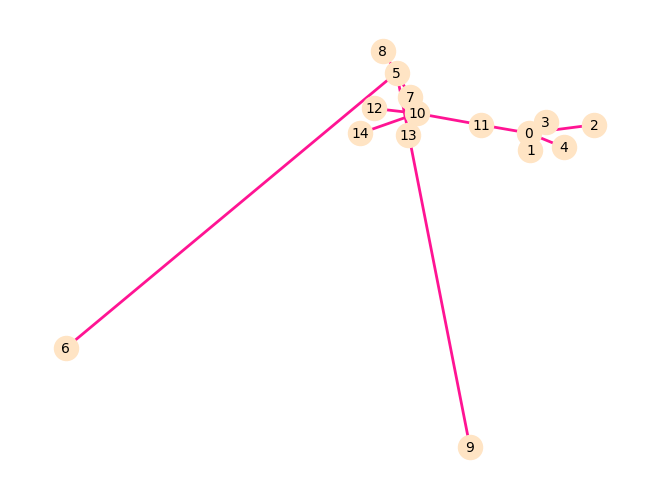

this is A_dict: 
{'0_3': [['a', 'a'], ['c', 'g'], ['a', 'a'], ['g', 'g'], ['a', 'a'], ['c', 'c'], ['c', 'c'], ['t', 't'], ['g', 'g'], ['t', 'c'], ['g', 'g'], ['g', 't'], ['c', 'c'], ['a', 'a']], '0_2': [['a', 'a'], ['g', 'a'], ['a', 'a'], ['g', 'g'], ['a', 'a'], ['c', 'c'], ['c', 'c'], ['t', 't'], ['g', 'g'], ['c', 'c'], ['g', 'g'], ['t', 't'], ['c', 'c'], ['a', 'a']], '0_4': [['a', 'a'], ['g', 'g'], ['a', 'a'], ['g', 'g'], ['a', 'a'], ['c', 'c'], ['c', 'c'], ['t', 't'], ['g', 'g'], ['c', 'c'], ['g', 'g'], ['t', 't'], ['c', 'c'], ['a', 't']], '0_11': [['a', 'a'], ['g', 'g'], ['a', 'g'], ['g', 'g'], ['a', 'g'], ['c', 'g'], ['c', 'c'], ['t', 't'], ['g', 'g'], ['c', 'c'], ['g', 'g'], ['t', 't'], ['c', 'c'], ['a', 'a']], '0_1': [['a', 'a'], ['g', 'g'], ['a', 'a'], ['g', 'g'], ['a', 'a'], ['c', 'c'], ['c', 'c'], ['t', 't'], ['g', 'c'], ['c', 'c'], ['g', 'g'], ['t', 't'], ['c', 'g'], ['a', 'a']], '10_11': [['a', 'a'], ['g', 'g'], ['g', 'c'], ['g', 'g'], ['g', 'g'], ['g', 'g'], ['c', 'c'], ['

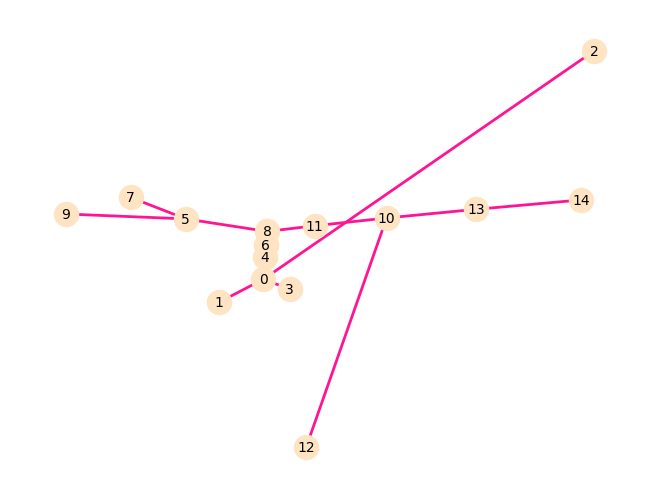

this is A_dict: 
{'0_4': [['g', 'g'], ['a', 'a'], ['g', 'g'], ['g', 'g'], ['a', 'a'], ['g', 'g'], ['a', 'a'], ['t', 't'], ['g', 'g'], ['a', 'a'], ['t', 't'], ['a', 'a'], ['g', 'g'], ['g', 'g'], ['g', 't'], ['g', 'g'], ['g', 'g']], '4_6': [['g', 'g'], ['a', 'g'], ['g', 'g'], ['g', 't'], ['a', 'a'], ['g', 'g'], ['a', 'a'], ['t', 't'], ['g', 'a'], ['a', 't'], ['t', 'c'], ['a', 't'], ['g', 'a'], ['g', 'g'], ['g', 'g'], ['g', 'a'], ['g', 'g']], '0_2': [['g', 'g'], ['a', 'a'], ['g', 'g'], ['g', 'g'], ['a', 'a'], ['g', 'g'], ['a', 'a'], ['t', 't'], ['g', 'g'], ['a', 'a'], ['t', 't'], ['a', 'a'], ['g', 'g'], ['g', 'g'], ['t', 't'], ['g', 'g'], ['g', 'g']], '0_1': [['g', 'g'], ['a', 'a'], ['g', 'g'], ['g', 'g'], ['a', 'a'], ['g', 'g'], ['a', 'a'], ['t', 't'], ['g', 'g'], ['a', 'a'], ['t', 'c'], ['a', 'a'], ['g', 'g'], ['g', 'g'], ['t', 't'], ['g', 'g'], ['g', 'g']], '0_3': [['g', 'g'], ['a', 'a'], ['g', 'g'], ['g', 'g'], ['a', 'a'], ['g', 'c'], ['a', 'a'], ['t', 't'], ['g', 'g'], ['a', 'a'], ['

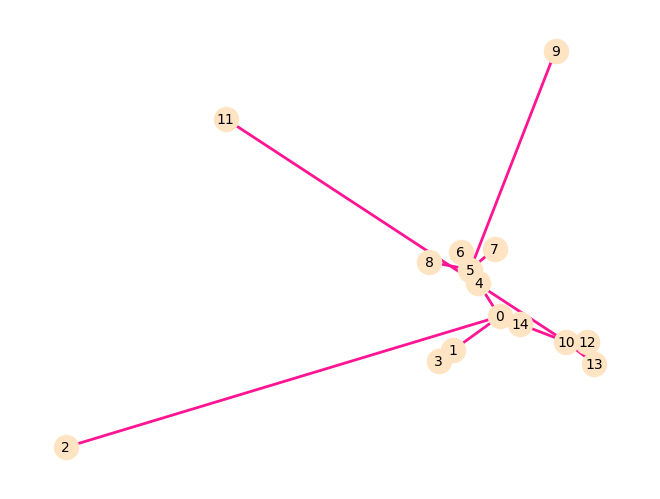

this is A_dict: 
{'1_3': [['a', 'a'], ['t', 't'], ['c', 'c'], ['g', 'g'], ['t', 'c'], ['c', 'c'], ['t', 'g'], ['c', 'c'], ['a', 'a'], ['a', 'a'], ['c', 'c'], ['a', 'a'], ['g', 'g'], ['g', 'g'], ['g', 't'], ['t', 'g'], ['a', 'a']], '0_1': [['a', 'a'], ['t', 't'], ['c', 'c'], ['g', 'g'], ['c', 'c'], ['c', 'c'], ['g', 'g'], ['c', 'c'], ['a', 'a'], ['a', 'a'], ['c', 'c'], ['a', 'a'], ['g', 'g'], ['g', 'a'], ['t', 't'], ['g', 'g'], ['a', 'a']], '0_2': [['a', 'a'], ['t', 't'], ['c', 'c'], ['g', 'g'], ['c', 'c'], ['c', 'c'], ['g', 'g'], ['c', 'c'], ['a', 'a'], ['a', 'a'], ['c', 'c'], ['a', 'a'], ['g', 'g'], ['a', 'a'], ['t', 't'], ['g', 'g'], ['a', 'a']], '0_4': [['a', 'c'], ['t', 't'], ['c', 'c'], ['g', 'g'], ['c', 'c'], ['c', 'c'], ['g', 'g'], ['c', 'c'], ['a', 'a'], ['a', 'a'], ['c', 'c'], ['a', 'a'], ['g', 'g'], ['a', 'a'], ['t', 't'], ['g', 'g'], ['a', 'a']], '0_14': [['a', 'g'], ['-', 't'], ['t', 't'], ['c', 'c'], ['g', 'g'], ['c', 'c'], ['-', 'a'], ['c', 'c'], ['g', 'a'], ['c', 'c'], [

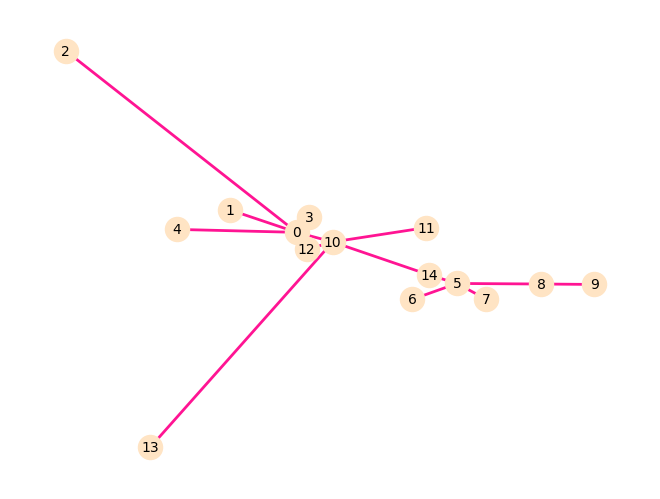

this is A_dict: 
{'0_2': [['c', 'c'], ['c', 'c'], ['a', 'a'], ['g', 'g'], ['a', 'a'], ['a', 'a'], ['g', 'g'], ['t', 't'], ['g', 'g'], ['g', 'g'], ['c', 'c'], ['a', 'a'], ['g', 'g'], ['a', 'a'], ['a', 'a'], ['g', 'g'], ['g', 'g']], '0_1': [['c', 'c'], ['c', 'c'], ['a', 'a'], ['g', 'g'], ['a', 'a'], ['a', 'a'], ['g', 'g'], ['t', 't'], ['g', 'a'], ['g', 'g'], ['c', 'c'], ['a', 'a'], ['g', 'g'], ['a', 'a'], ['a', 'a'], ['g', 'g'], ['g', 'g']], '0_4': [['c', 'c'], ['c', 'c'], ['a', 'a'], ['g', 'g'], ['a', 'a'], ['a', 'a'], ['g', 'g'], ['t', 't'], ['g', 'g'], ['g', 'g'], ['c', 'c'], ['a', 'a'], ['g', 'a'], ['a', 'a'], ['a', 'a'], ['g', 'g'], ['g', 'g']], '0_3': [['c', 'c'], ['c', 'c'], ['a', 'a'], ['g', 'g'], ['a', 'a'], ['a', 'a'], ['g', 'g'], ['t', 't'], ['g', 'g'], ['g', 'g'], ['c', 'c'], ['a', 'a'], ['g', 'g'], ['a', 't'], ['a', 'a'], ['g', 'g'], ['g', 'g']], '0_10': [['c', 'c'], ['c', 'a'], ['a', 'a'], ['g', 't'], ['a', 'a'], ['a', 't'], ['g', 'g'], ['t', 't'], ['g', 'g'], ['g', 'g'], [

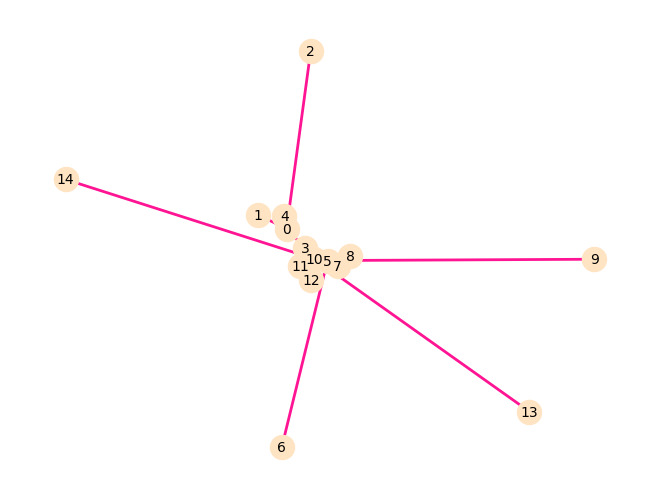

this is A_dict: 
{'0_4': [['c', 'g'], ['a', 'a'], ['a', 'a'], ['g', 'g'], ['g', 'g'], ['g', 'g'], ['c', 'c'], ['a', 'a'], ['t', 't'], ['a', 'a'], ['g', 'g'], ['t', 't'], ['a', 'a'], ['a', 'a'], ['g', 'g'], ['c', 'c'], ['a', 'a'], ['a', 'a'], ['g', 't']], '0_2': [['g', 'g'], ['a', 'a'], ['a', 'a'], ['g', 'g'], ['g', 'g'], ['g', 'g'], ['c', 'c'], ['a', 'a'], ['t', 't'], ['a', 'a'], ['g', 'g'], ['t', 't'], ['a', 'a'], ['a', 'a'], ['g', 'g'], ['c', 'c'], ['a', 'a'], ['a', 'a'], ['t', 't']], '0_1': [['g', 'g'], ['a', 'a'], ['a', 'a'], ['g', 'g'], ['g', 'g'], ['g', 'g'], ['c', 'c'], ['a', 'a'], ['t', 't'], ['a', 'a'], ['g', 'g'], ['t', 't'], ['a', 'g'], ['a', 'a'], ['g', 'g'], ['c', 'c'], ['a', 'a'], ['a', 'a'], ['t', 't']], '0_3': [['g', 'g'], ['a', 'a'], ['a', 'a'], ['g', 'g'], ['g', 'g'], ['g', 'g'], ['c', 'c'], ['a', 'a'], ['t', 't'], ['a', 'a'], ['g', 'g'], ['t', 't'], ['a', 'a'], ['a', 'c'], ['g', 'g'], ['c', 'c'], ['a', 'a'], ['a', 'a'], ['t', 't']], '3_10': [['g', 'c'], ['a', 'a'], [

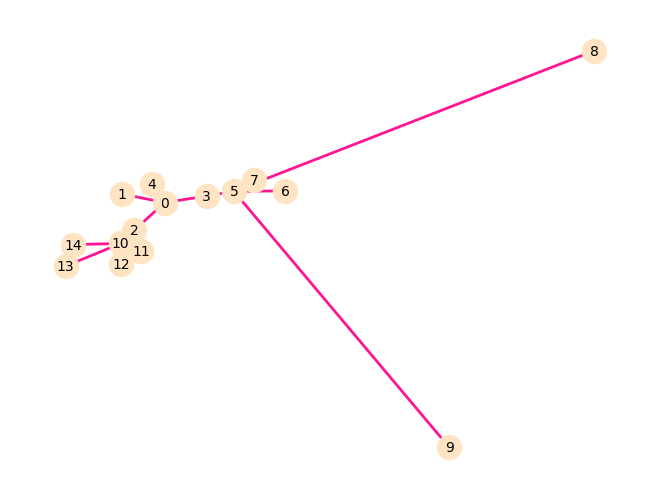

this is A_dict: 
{'0_4': [['a', 'a'], ['t', 't'], ['t', 't'], ['c', 'c'], ['c', 'c'], ['a', 'a'], ['c', 'c'], ['c', 'c'], ['g', 'g'], ['g', 'g'], ['a', 'a'], ['g', 'g'], ['a', 'a'], ['t', 't'], ['t', 't'], ['a', 'a'], ['t', 'g']], '0_1': [['a', 'a'], ['t', 't'], ['t', 't'], ['c', 'c'], ['c', 'c'], ['a', 'a'], ['c', 'c'], ['c', 'c'], ['g', 'g'], ['g', 'g'], ['a', 'a'], ['g', 'g'], ['a', 'a'], ['t', 't'], ['t', 'g'], ['a', 'a'], ['g', 'g']], '0_2': [['a', 'a'], ['t', 't'], ['t', 't'], ['c', 'c'], ['c', 'c'], ['a', 'a'], ['c', 'c'], ['c', 'a'], ['g', 'g'], ['g', 'g'], ['a', 'a'], ['g', 'g'], ['a', 'a'], ['t', 't'], ['t', 't'], ['a', 'a'], ['g', 'g']], '0_3': [['a', 'a'], ['t', 't'], ['t', 't'], ['c', 'g'], ['c', 'c'], ['a', 'a'], ['c', 'c'], ['c', 'c'], ['g', 'a'], ['g', 'g'], ['a', 't'], ['g', 'g'], ['a', 'a'], ['t', 'c'], ['t', 't'], ['a', 'a'], ['g', 'g']], '2_10': [['-', 'a'], ['a', 'a'], ['t', 't'], ['t', 't'], ['c', 'g'], ['c', 't'], ['a', 'a'], ['c', 'c'], ['a', 'g'], ['g', 'g'], [

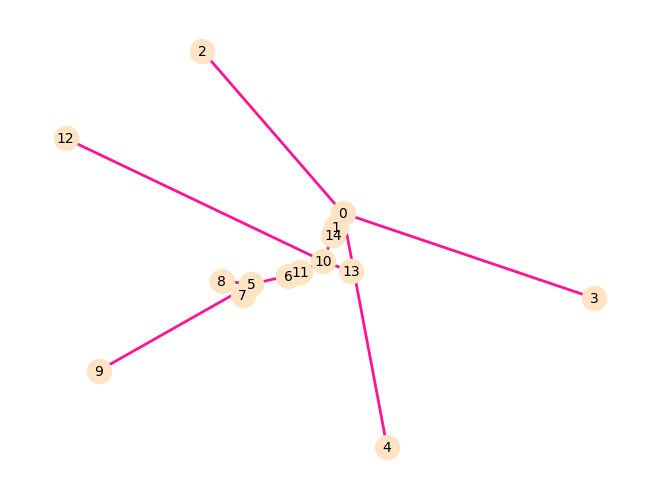

this is A_dict: 
{'0_2': [['a', 'a'], ['g', 'g'], ['t', 't'], ['t', 't'], ['a', 'a'], ['g', 'g'], ['a', 'a'], ['g', 'g'], ['t', 't'], ['a', 'a'], ['g', 'g'], ['c', 'c'], ['c', 'c'], ['c', 'c'], ['a', 'a'], ['g', 'g']], '0_3': [['a', 'a'], ['g', 'g'], ['t', 't'], ['t', 't'], ['a', 'a'], ['g', 'g'], ['a', 'a'], ['g', 'g'], ['t', 't'], ['a', 'a'], ['g', 'g'], ['c', 'c'], ['c', 'c'], ['c', 'c'], ['a', 'a'], ['g', 'g']], '0_4': [['a', 'a'], ['g', 'g'], ['t', 't'], ['t', 't'], ['a', 'a'], ['g', 'g'], ['a', 'a'], ['g', 'g'], ['t', 't'], ['a', 'a'], ['g', 'g'], ['c', 'c'], ['c', 'c'], ['c', 'c'], ['a', 'a'], ['g', 'g']], '0_1': [['a', 'a'], ['g', 'g'], ['t', 't'], ['t', 'g'], ['a', 'a'], ['g', 'g'], ['a', 'a'], ['g', 'g'], ['t', 't'], ['a', 'a'], ['g', 'g'], ['c', 'c'], ['c', 'c'], ['c', 'c'], ['a', 'a'], ['g', 'g']], '1_14': [['-', 't'], ['a', 'c'], ['g', 'a'], ['t', 't'], ['g', 'a'], ['a', 'a'], ['g', 'g'], ['a', 'a'], ['g', 't'], ['t', 'c'], ['a', 'g'], ['g', 'g'], ['c', '-'], ['c', 'g'], [

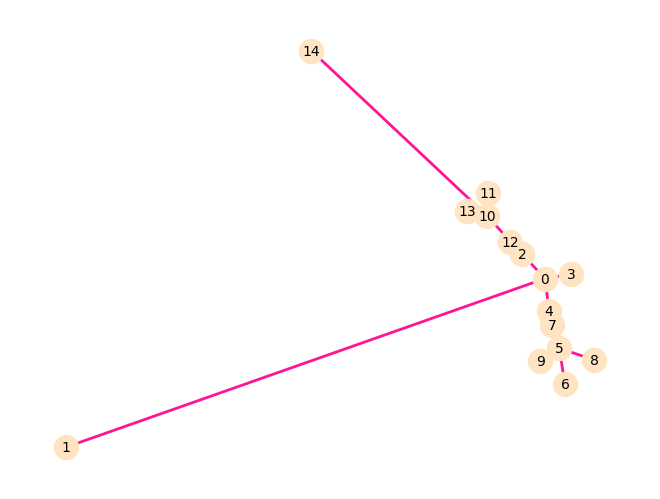

this is A_dict: 
{'5_8': [['g', 'g'], ['a', 'a'], ['g', 'g'], ['c', 'c'], ['t', 't'], ['g', 'g'], ['g', 'g'], ['c', 'c'], ['g', 'g'], ['t', 't'], ['t', 't'], ['c', 'c'], ['c', 'c'], ['c', 'c'], ['g', 'g'], ['t', 't'], ['t', 'a']], '5_6': [['g', 'g'], ['a', 'a'], ['g', 'g'], ['c', 'c'], ['t', 't'], ['g', 'a'], ['g', 'g'], ['c', 'c'], ['g', 'g'], ['t', 't'], ['t', 't'], ['c', 'c'], ['c', 'c'], ['c', 'c'], ['g', 'g'], ['t', 't'], ['a', 'a']], '5_9': [['g', 'a'], ['a', 'a'], ['g', 'g'], ['c', 'c'], ['t', 't'], ['g', 'g'], ['g', 'a'], ['c', 'g'], ['g', 'g'], ['t', 't'], ['t', 't'], ['c', 'c'], ['c', 'c'], ['c', 'c'], ['g', 'g'], ['t', 't'], ['a', 'a']], '5_7': [['g', 'c'], ['a', 'a'], ['g', 'g'], ['c', 'c'], ['t', 't'], ['g', 'g'], ['g', 'g'], ['c', 'c'], ['g', 'g'], ['t', 'g'], ['t', 't'], ['c', 'c'], ['c', 'c'], ['c', 'c'], ['g', 'g'], ['t', 't'], ['a', 'a']], '4_7': [['c', '-'], ['a', 'g'], ['g', 'a'], ['c', 'c'], ['t', 'c'], ['g', 'g'], ['g', 't'], ['c', 'c'], ['g', 'a'], ['g', 'g'], ['

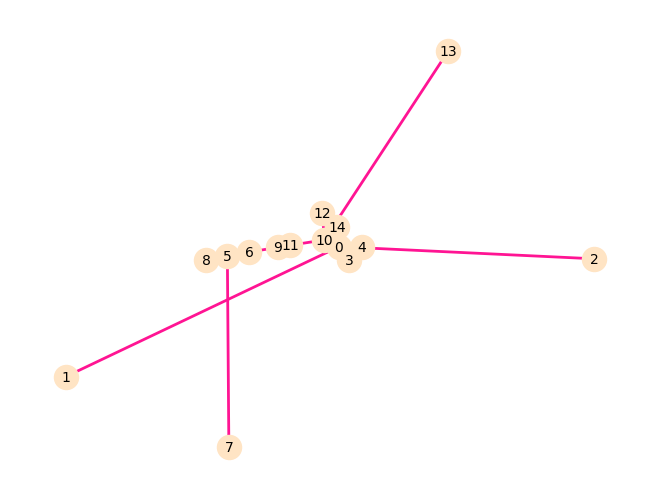

this is A_dict: 
{'0_4': [['c', 'c'], ['t', 't'], ['t', 't'], ['t', 'c'], ['t', 't'], ['c', 'c'], ['g', 'g'], ['g', 'g'], ['g', 'g'], ['a', 'a'], ['g', 'g'], ['c', 'c'], ['a', 'g'], ['g', 'g'], ['g', 'a'], ['c', 'c']], '0_1': [['c', 'c'], ['t', 't'], ['t', 't'], ['c', 'c'], ['t', 't'], ['c', 'c'], ['g', 'g'], ['g', 'g'], ['g', 'g'], ['a', 'a'], ['g', 'g'], ['c', 'c'], ['g', 'g'], ['g', 'g'], ['a', 'a'], ['c', 'c']], '0_2': [['c', 'c'], ['t', 't'], ['t', 't'], ['c', 'c'], ['t', 't'], ['c', 'c'], ['g', 'g'], ['g', 'g'], ['g', 'g'], ['a', 'a'], ['g', 'g'], ['c', 'c'], ['g', 'g'], ['g', 'g'], ['a', 'a'], ['c', 'c']], '0_3': [['c', 'a'], ['t', 't'], ['t', 't'], ['c', 'c'], ['t', 't'], ['c', 'c'], ['g', 'a'], ['g', 'g'], ['g', 'g'], ['a', 'a'], ['g', 'g'], ['c', 'c'], ['g', 'g'], ['g', 'g'], ['a', 'a'], ['c', 'c']], '0_10': [['c', 'c'], ['t', 't'], ['t', 't'], ['c', 'c'], ['t', 'a'], ['c', 't'], ['g', 'g'], ['g', 'a'], ['g', 'g'], ['a', 'a'], ['g', 'g'], ['c', 'g'], ['g', 'g'], ['g', 'g'], [

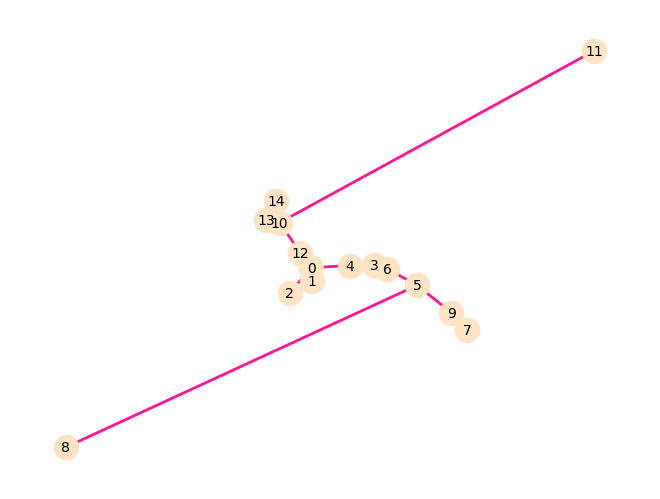

this is A_dict: 
{'0_1': [['t', 't'], ['t', 't'], ['t', 'c'], ['c', 'c'], ['g', 'g'], ['a', 'a'], ['g', 't'], ['c', 'c'], ['c', 'g'], ['t', 't'], ['t', 't'], ['g', 'g'], ['a', 'a'], ['g', 'g'], ['g', 'c'], ['g', 'g'], ['t', 'a'], ['a', 'a']], '0_2': [['t', 't'], ['t', 't'], ['c', 'c'], ['c', 'c'], ['g', 'g'], ['a', 'a'], ['t', 't'], ['c', 'c'], ['g', 'g'], ['t', 't'], ['t', 'c'], ['g', 'g'], ['a', 'a'], ['g', 'g'], ['c', 'c'], ['g', 'g'], ['a', 'a'], ['a', 'g']], '0_4': [['t', 't'], ['t', 't'], ['c', 'g'], ['c', 'c'], ['g', 'g'], ['a', 'a'], ['t', 't'], ['c', 'c'], ['g', 'g'], ['t', 't'], ['t', 't'], ['g', 'g'], ['a', 'a'], ['g', 'g'], ['c', 'c'], ['g', 'g'], ['a', 'a'], ['a', 'a']], '0_12': [['t', 'a'], ['t', 't'], ['c', 'c'], ['c', 'c'], ['g', 'g'], ['a', 'a'], ['t', 'g'], ['c', 'g'], ['g', 'g'], ['t', 'g'], ['t', 't'], ['g', 'a'], ['a', 'a'], ['g', 'g'], ['c', 'a'], ['g', 'g'], ['a', 'a'], ['a', 'a']], '3_4': [['t', 't'], ['t', 't'], ['g', 'a'], ['c', 'c'], ['g', 'g'], ['a', 'a'], [

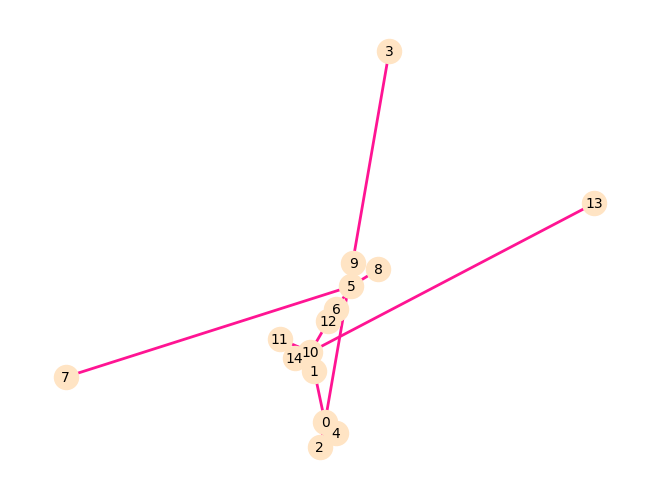

this is A_dict: 
{'5_9': [['t', 't'], ['c', 'c'], ['g', 'g'], ['c', 'c'], ['g', 'g'], ['a', 'a'], ['a', 'a'], ['g', 'g'], ['t', 't'], ['t', 't'], ['c', 'c'], ['g', 'g'], ['c', 'c'], ['c', 'a'], ['g', 'g']], '5_7': [['t', 't'], ['c', 'c'], ['g', 'g'], ['c', 'c'], ['g', 'g'], ['a', 'a'], ['a', 'a'], ['g', 'g'], ['t', 't'], ['t', 't'], ['c', 'c'], ['g', 'g'], ['c', 'c'], ['a', 'a'], ['g', 'g']], '5_8': [['t', 't'], ['c', 'c'], ['g', 'g'], ['c', 'c'], ['g', 'g'], ['a', 'g'], ['a', 'a'], ['g', 'g'], ['t', 't'], ['t', 't'], ['c', 'c'], ['g', 'g'], ['c', 'c'], ['a', 'a'], ['g', 'g']], '5_6': [['t', 't'], ['c', 'c'], ['g', 'g'], ['c', 'c'], ['g', 'g'], ['a', 'c'], ['a', 'a'], ['g', 'a'], ['t', 't'], ['t', 't'], ['c', 'c'], ['g', 'g'], ['c', 'c'], ['a', 'a'], ['g', 'g']], '6_12': [['t', 'g'], ['c', 'a'], ['g', 'a'], ['c', 'g'], ['g', 'g'], ['c', 'c'], ['a', 'a'], ['a', 'a'], ['t', 't'], ['t', 'g'], ['c', 'a'], ['g', 'g'], ['c', 'a'], ['a', 'a'], ['g', 'g']], '10_12': [['g', 'g'], ['a', 'a'], ['

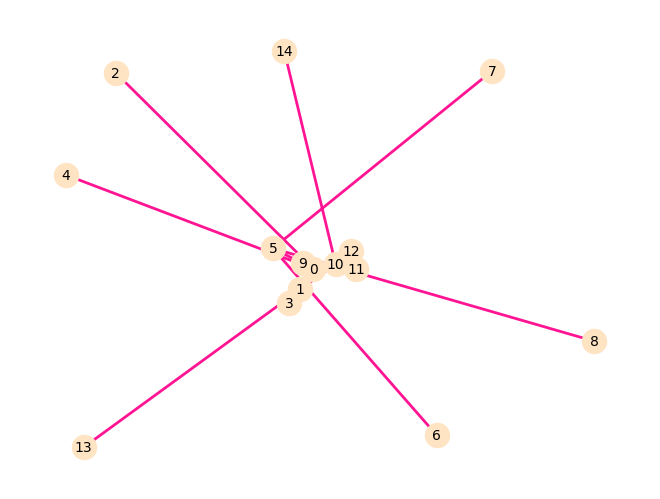

this is A_dict: 
{'5_6': [['a', 'a'], ['t', 't'], ['t', 't'], ['c', 'c'], ['c', 'c'], ['g', 'g'], ['t', 't'], ['g', 'g'], ['a', 'a'], ['t', 't'], ['c', 'c'], ['a', 'a'], ['a', 'a'], ['g', 'g']], '5_7': [['a', 'a'], ['t', 't'], ['t', 't'], ['c', 'c'], ['c', 'c'], ['g', 'g'], ['t', 't'], ['g', 'g'], ['a', 'a'], ['t', 't'], ['c', 'c'], ['a', 'a'], ['a', 'a'], ['g', 'g']], '5_8': [['a', 'a'], ['t', 't'], ['t', 't'], ['c', 'c'], ['c', 'c'], ['g', 'g'], ['t', 't'], ['g', 'g'], ['a', 'a'], ['t', 't'], ['c', 'c'], ['a', 'a'], ['a', 'a'], ['g', 'g']], '5_9': [['a', 'g'], ['t', 't'], ['t', 't'], ['c', 'c'], ['c', 'c'], ['g', 'g'], ['t', 't'], ['g', 'g'], ['a', 'a'], ['t', 't'], ['c', 'c'], ['a', 'a'], ['a', 'a'], ['g', 'g']], '0_9': [['g', 'g'], ['t', 'a'], ['t', 'g'], ['c', 'g'], ['c', 't'], ['g', 'a'], ['t', 't'], ['g', 'g'], ['-', 'c'], ['a', 'a'], ['t', 't'], ['c', 't'], ['a', '-'], ['a', 'a'], ['g', 'g']], '0_2': [['g', 'g'], ['a', 'a'], ['g', 'g'], ['g', 'g'], ['t', 't'], ['a', 'a'], ['t',

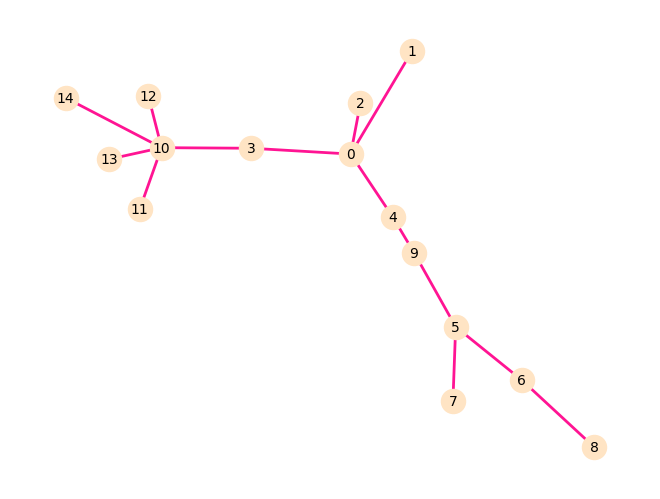

this is A_dict: 
{'6_8': [['g', 'g'], ['g', 'g'], ['g', 'g'], ['a', 'a'], ['a', 'a'], ['c', 'c'], ['g', 'g'], ['t', 't'], ['g', 'g'], ['a', 'g'], ['a', 'a'], ['t', 't'], ['c', 'c'], ['t', 't'], ['a', 'a'], ['c', 'c'], ['t', 't'], ['g', 'g']], '5_6': [['g', 'g'], ['g', 'g'], ['g', 'g'], ['a', 'a'], ['a', 'a'], ['c', 'c'], ['g', 'g'], ['t', 't'], ['g', 'g'], ['a', 't'], ['a', 'a'], ['t', 't'], ['c', 'c'], ['t', 't'], ['a', 'a'], ['c', 'c'], ['t', 't'], ['g', 'g']], '5_7': [['g', 'g'], ['g', 'g'], ['g', 'g'], ['a', 'a'], ['a', 'a'], ['c', 'c'], ['g', 'g'], ['t', 'a'], ['g', 'g'], ['t', 't'], ['a', 'a'], ['t', 't'], ['c', 'c'], ['t', 't'], ['a', 'a'], ['c', 'c'], ['t', 't'], ['g', 'g']], '5_9': [['g', 'g'], ['g', 'g'], ['g', 'g'], ['a', 'a'], ['a', 'a'], ['c', 'c'], ['g', 'c'], ['t', 't'], ['g', 'a'], ['t', 't'], ['a', 'a'], ['t', 't'], ['c', 'c'], ['t', 't'], ['a', 'a'], ['c', 't'], ['t', 't'], ['g', 'g']], '4_9': [['g', 'a'], ['g', 'g'], ['g', 'c'], ['a', 'c'], ['a', 'a'], ['c', 'c'], ['

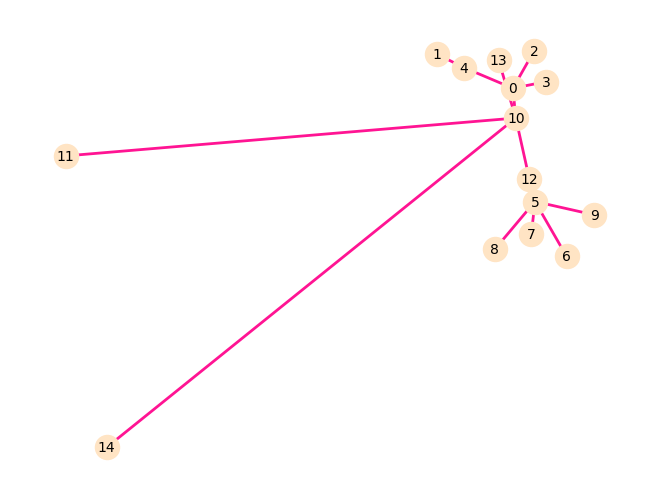

this is A_dict: 
{'0_2': [['t', 't'], ['c', 'c'], ['a', 'a'], ['c', 'c'], ['a', 'a'], ['c', 'c'], ['a', 'a'], ['t', 't'], ['g', 'g'], ['a', 'a'], ['t', 't'], ['t', 't'], ['c', 'c'], ['c', 'a'], ['t', 't'], ['t', 't'], ['c', 'c'], ['c', 'c']], '0_4': [['t', 't'], ['c', 'c'], ['a', 'a'], ['c', 'c'], ['a', 'a'], ['c', 'c'], ['a', 'a'], ['t', 'a'], ['g', 'g'], ['a', 'a'], ['t', 't'], ['t', 't'], ['c', 'c'], ['a', 'a'], ['t', 't'], ['t', 't'], ['c', 'c'], ['c', 'c']], '0_3': [['t', 't'], ['c', 'c'], ['a', 'a'], ['c', 'c'], ['a', 'a'], ['c', 'g'], ['a', 'a'], ['t', 'c'], ['g', 'g'], ['a', 'a'], ['t', 't'], ['t', 't'], ['c', 'c'], ['a', 'a'], ['t', 't'], ['t', 't'], ['c', 'c'], ['c', 'c']], '0_10': [['t', 'c'], ['c', 'c'], ['a', 'a'], ['c', 't'], ['a', 'g'], ['c', 'c'], ['a', 'a'], ['t', 't'], ['g', 'g'], ['a', 'g'], ['t', 'a'], ['t', 'g'], ['c', 'c'], ['a', 'a'], ['t', 't'], ['t', 't'], ['c', 'c'], ['c', 'c']], '1_4': [['t', 't'], ['c', 'c'], ['a', 'a'], ['c', 'a'], ['a', 'a'], ['c', 'c'], [

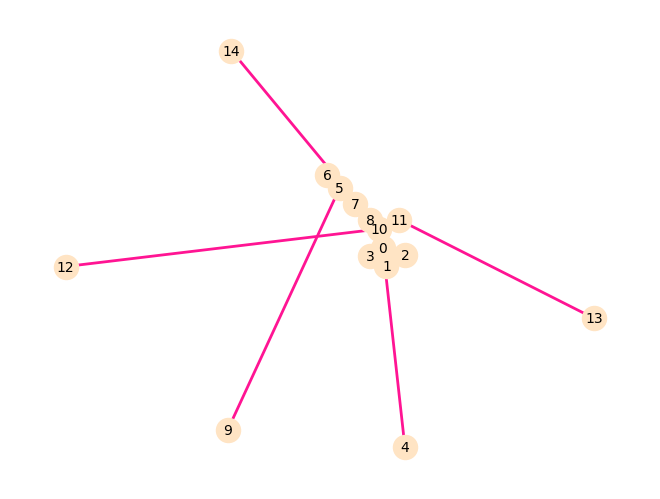

this is A_dict: 
{'0_1': [['t', 't'], ['t', 't'], ['c', 'c'], ['a', 'a'], ['t', 't'], ['a', 'a'], ['t', 't'], ['c', 'g'], ['c', 'c'], ['c', 'c'], ['c', 'c'], ['t', 't'], ['t', 't'], ['t', 't']], '0_4': [['t', 't'], ['t', 't'], ['c', 'c'], ['a', 'a'], ['t', 't'], ['a', 'a'], ['t', 't'], ['g', 'g'], ['c', 'c'], ['c', 'c'], ['c', 'c'], ['t', 't'], ['t', 't'], ['t', 't']], '0_2': [['t', 't'], ['t', 't'], ['c', 'c'], ['a', 'a'], ['t', 't'], ['a', 't'], ['t', 't'], ['g', 'g'], ['c', 'c'], ['c', 'c'], ['c', 'c'], ['t', 't'], ['t', 't'], ['t', 't']], '0_10': [['t', 't'], ['t', 't'], ['c', 't'], ['a', 'a'], ['t', 't'], ['a', 'a'], ['t', 't'], ['g', 'g'], ['c', 'c'], ['c', 'a'], ['c', 'c'], ['t', 't'], ['t', 't'], ['t', 'c']], '0_3': [['t', 't'], ['t', 't'], ['c', 'c'], ['a', 'a'], ['t', 'a'], ['a', 'a'], ['t', 'a'], ['g', 'g'], ['c', 'c'], ['c', 'c'], ['c', 'c'], ['t', 't'], ['t', 't'], ['t', 't']], '10_12': [['t', 't'], ['t', 't'], ['t', 't'], ['a', 'a'], ['t', 't'], ['a', 'a'], ['t', 't'], ['

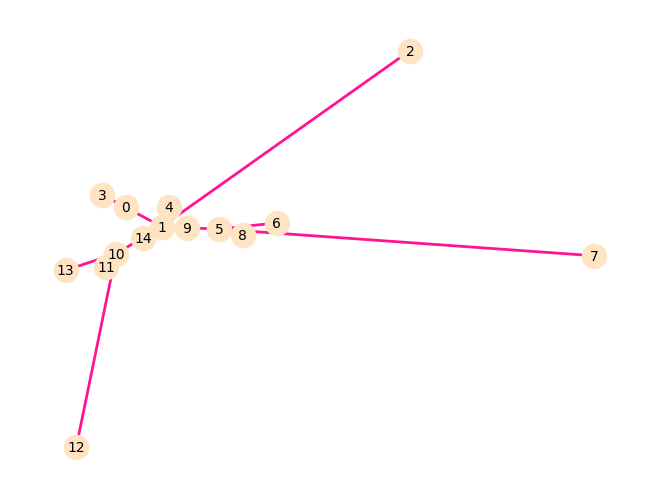

this is A_dict: 
{'0_3': [['c', 'c'], ['a', 'a'], ['a', 'c'], ['g', 'g'], ['a', 'a'], ['a', 'a'], ['c', 'c'], ['t', 't'], ['a', 'a'], ['a', 'a'], ['c', 'c'], ['c', 'c'], ['t', 't'], ['g', 'g'], ['t', 'c'], ['g', 'g'], ['c', 'c'], ['g', 'g']], '0_1': [['c', 'c'], ['a', 'a'], ['c', 'c'], ['g', 'g'], ['a', 'a'], ['a', 'a'], ['c', 'c'], ['t', 't'], ['a', 'a'], ['a', 'a'], ['c', 'c'], ['c', 'c'], ['t', 'a'], ['g', 'g'], ['c', 'c'], ['g', 'g'], ['c', 'c'], ['g', 'g']], '1_2': [['c', 'c'], ['a', 'a'], ['c', 'c'], ['g', 'g'], ['a', 'a'], ['a', 'a'], ['c', 'c'], ['t', 't'], ['a', 'a'], ['a', 'a'], ['c', 'c'], ['c', 'c'], ['a', 'a'], ['g', 'g'], ['c', 'c'], ['g', 'g'], ['c', 'c'], ['g', 'g']], '1_4': [['c', 'c'], ['a', 'a'], ['c', 'c'], ['g', 'g'], ['a', 'a'], ['a', 'a'], ['c', 'c'], ['t', 't'], ['a', 'a'], ['a', 'a'], ['c', 'c'], ['c', 'c'], ['a', 'a'], ['g', 'c'], ['c', 'c'], ['g', 'g'], ['c', 'c'], ['g', 'g']], '1_14': [['c', 'c'], ['a', 'a'], ['c', 'a'], ['g', 't'], ['a', 'g'], ['a', 'a'], [

In [15]:
costs_new_gradual=[]
costs_new_one_by_one=[]
costs_old=[]

for random_pile in big_collection_in_families:
    cost=new_assembly(random_pile,score_matrix,gap_cost)[4]
    costs_new_gradual.append(cost)
for random_pile in big_collection_in_families:
    cost=new_sp_approxi_combi(random_pile,score_matrix,gap_cost)[0]
    costs_new_one_by_one.append(cost)
for random_pile in big_collection_in_families:
    cost=sp_approx(random_pile,score_matrix,gap_cost)[0]
    costs_old.append(cost)
print(costs_new_gradual)
print(costs_new_one_by_one)
print(costs_old)
costs_new_gradual=np.array(costs_new_gradual)
costs_new_one_by_one=np.array(costs_new_one_by_one)
costs_old=np.array(costs_old)
differences_obo_old=np.subtract(costs_new_one_by_one,costs_old)
differences_gradual_old=np.subtract(costs_new_gradual,costs_old)
differences_gradual_obo=np.subtract(costs_new_gradual,costs_new_one_by_one)
print(differences_obo_old, differences_gradual_obo,differences_gradual_obo)

In [16]:
count_diff_obo_old=(np.count_nonzero(differences_obo_old<0),len(differences_obo_old[differences_obo_old == 0])) #times one by one was better or equal than old
count_diff_gradual_old=(np.count_nonzero(differences_gradual_old<0),len(differences_gradual_old[differences_gradual_old == 0])) #times gradual was better or equal than old
count_diff_gradual_obo=(np.count_nonzero(differences_gradual_obo<0),len(differences_gradual_obo[differences_gradual_obo == 0])) #times gradual was better or equal than one by one
print(count_diff_obo_old,count_diff_gradual_old,count_diff_gradual_obo)

(10, 1) (10, 1) (0, 20)


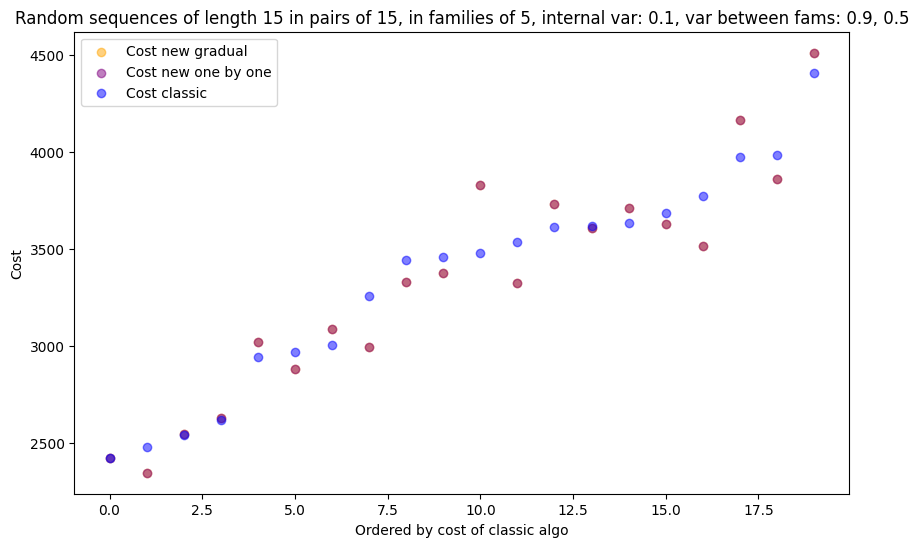

In [19]:
#costs_new_gradual
#costs_new_one_by_one
#costs_old

indices = list(range(0, 20))


# Get the indices that would sort cost_old array
sorted_indices = np.argsort(costs_old)

# Sort all arrays based on the order in cost_old
sorted_costs_old = np.array(costs_old)[sorted_indices]
sorted_costs_new_gradual = np.array(costs_new_gradual)[sorted_indices]
sorted_costs_new_one_by_one = np.array(costs_new_one_by_one)[sorted_indices]
sorted_indices = np.array(indices)[sorted_indices]

# Plot the sorted data
plt.figure(figsize=(10, 6))
plt.scatter(indices, sorted_costs_new_gradual, color='orange', label='Cost new gradual', marker='o', alpha=0.5)
plt.scatter(indices, sorted_costs_new_one_by_one, color='purple', label='Cost new one by one', marker='o', alpha=0.5)
plt.scatter(indices, sorted_costs_old, color='blue', label='Cost classic', marker='o', alpha=0.5)

plt.xlabel('Ordered by cost of classic algo')
plt.ylabel('Cost')
plt.title('Random sequences of length 15 in pairs of 15, in families of 5, internal var: 0.1, var between fams: 0.9, 0.5') #(2, 5, 15, [0.1, 0.1,0.1], [0, 0.9,0.5]
plt.legend()


plt.savefig('scatter_plot_family_seqs_len15_3fams.png')
plt.show()


In [126]:
def make_related_strings(nr_of_str:int,len_of_str, degree_of_variation:float, start_string):
    string_fam_collection=[]
    first_string=[]
    if start_string==False:
        for k in range(0,random.randrange((len_of_str-1),len_of_str+5)):
                first_string.append(random.choice(['a','c','t','g']))
        first_string=''.join(first_string)
        string_fam_collection.append(first_string)
    else:
         first_string=start_string
         string_fam_collection.append(first_string)

    for i in range(1,nr_of_str):
        a_sequence=[]
        for element in first_string:
            if random.random() < degree_of_variation: #checking if we should change the charachter
                a_sequence.append(random.choice(['a','c','t','g']))
            else:
                 a_sequence.append(element)
        a_sequence=''.join(a_sequence)
        string_fam_collection.append(a_sequence)
    return string_fam_collection

#make_related_strings(3,12,0.1,False)


def make_strings_in_families(nr_of_fams, nr_str_pr_fam, len_of_str, internal_var_in_fams, degree_of_var_from_first_fam):
    all_strings_coll = []
    first_family = make_related_strings(nr_str_pr_fam, len_of_str, internal_var_in_fams[0], start_string=False)
    all_strings_coll.append(first_family)
    
    for i in range(1, nr_of_fams):
        carry_over_string = first_family[0]
        mutated_carry_over = []
        for element in carry_over_string:
            if random.random() < degree_of_var_from_first_fam[i]:  # checking if we should change the character
                mutated_carry_over.append(random.choice(['a', 'c', 't', 'g']))
            else:
                mutated_carry_over.append(element)
        mutated_carry_over = ''.join(mutated_carry_over)  # Join the list of characters into a string
        family = make_related_strings(nr_str_pr_fam, len_of_str, internal_var_in_fams[i],mutated_carry_over)
        all_strings_coll.append(family)
    return all_strings_coll

make_strings_in_families(3, 2, 15, [0.1, 0.1,0.1], [0, 0.9,0.5])


[['gcgcatcataactct', 'gcgcaccataactct'],
 ['agttgaggaaagaag', 'agttgaggaacgatg'],
 ['gcgaatcataattct', 'gcgaatcataattct']]

Here comes the distance matrix produced by the alignments: 

[[ 0.  0.  0.]
 [nan nan nan]
 [nan nan nan]]
Here comes the distance matrix produced by the alignments: 

[[ 0.  0.  0.]
 [ 0.  0.  0.]
 [nan nan nan]]
Here comes the distance matrix produced by the alignments: 

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
matrix for MST: [['' '0' '0' '1']
 ['' '0' '0' '2']
 ['' '0' '1' '2']]
min span edges: [['*' '0' '0' '1']
 ['*' '0' '0' '2']
 ['' '0' '1' '2']]

 
 
 these are the nodes for the iteration 1
0 1
which correspond to these strings I align: acctgtatttatggtcca , acctgtatttatggtcca
original alignment, which is gonna be the guide[['a', 'a'], ['c', 'c'], ['c', 'c'], ['t', 't'], ['g', 'g'], ['t', 't'], ['a', 'a'], ['t', 't'], ['t', 't'], ['t', 't'], ['a', 'a'], ['t', 't'], ['g', 'g'], ['g', 'g'], ['t', 't'], ['c', 'c'], ['c', 'c'], ['a', 'a']]
<class 'dict'>
{'0': [0, 0], '1': [1, 0], '2': [2, 0]}
<class 'numpy.str_'>
<class 'numpy.str_'>
the node1 is right now in the alignment nr 0
the n

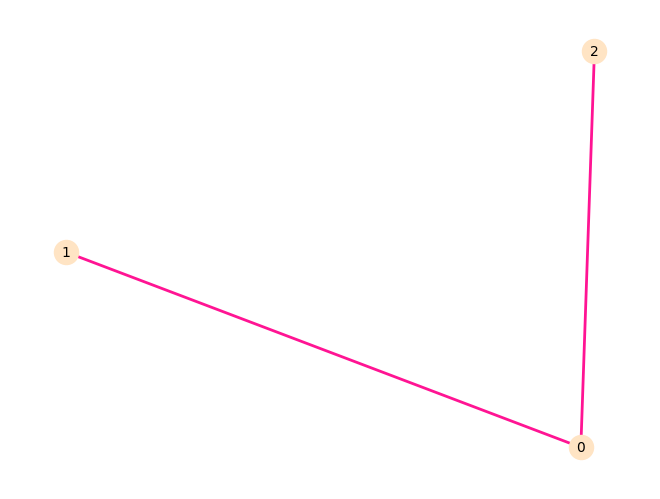

this is A_dict: 
{'0_1': [['a', 'a'], ['c', 'c'], ['c', 'c'], ['t', 't'], ['g', 'g'], ['t', 't'], ['a', 'a'], ['t', 't'], ['t', 't'], ['t', 't'], ['a', 'a'], ['t', 't'], ['g', 'g'], ['g', 'g'], ['t', 't'], ['c', 'c'], ['c', 'c'], ['a', 'a']], '0_2': [['a', 'a'], ['c', 'c'], ['c', 'c'], ['t', 't'], ['g', 'g'], ['t', 't'], ['a', 'a'], ['t', 't'], ['t', 't'], ['t', 't'], ['a', 'a'], ['t', 't'], ['g', 'g'], ['g', 'g'], ['t', 't'], ['c', 'c'], ['c', 'c'], ['a', 'a']]}
Total cost of MSA:0


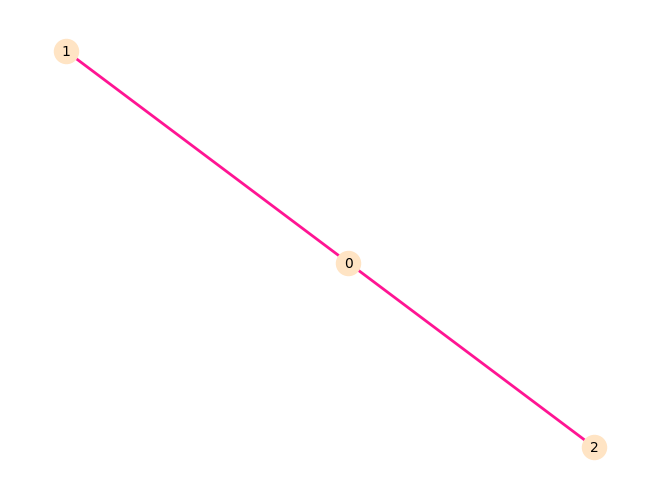

this is A_dict: 
{'0_1': [['c', 'c'], ['c', 'c'], ['t', 't'], ['g', 'g'], ['t', 't'], ['t', 't'], ['c', 'c'], ['c', 'c'], ['g', 'g'], ['a', 't'], ['a', 'a'], ['a', 'a'], ['c', 'c'], ['g', 'g'], ['g', 'g'], ['a', 'a'], ['c', 'c'], ['g', 'g']], '0_2': [['c', 'g'], ['c', 'c'], ['t', 'c'], ['g', 'g'], ['t', 't'], ['t', 't'], ['c', 'c'], ['c', 'c'], ['g', 'g'], ['t', 't'], ['a', 'a'], ['a', 'a'], ['c', 'c'], ['g', 'g'], ['g', 'g'], ['a', 'a'], ['c', 'c'], ['g', 'g']]}
Total cost of MSA:24


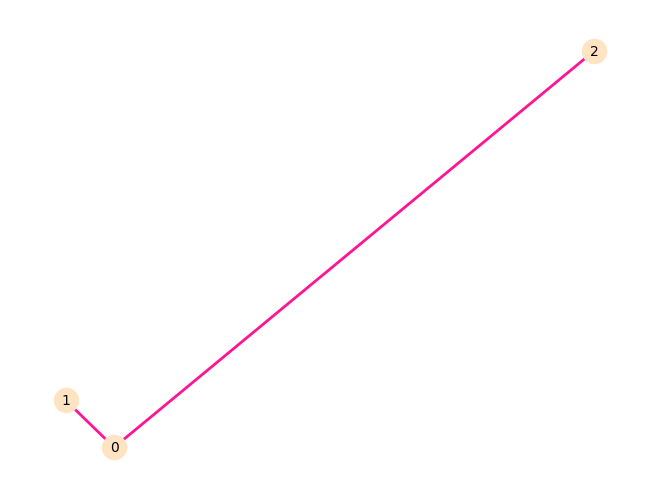

this is A_dict: 
{'0_2': [['c', 'c'], ['t', 't'], ['c', 'c'], ['a', 'a'], ['t', 't'], ['t', 't'], ['a', 'a'], ['t', 't'], ['g', 'g'], ['c', 'c'], ['t', 't'], ['t', 't'], ['t', 't'], ['t', 't'], ['g', 'g'], ['a', 'a'], ['a', 'a'], ['t', 't']], '0_1': [['c', 'c'], ['t', 'c'], ['c', 'c'], ['a', 'a'], ['t', 't'], ['t', 't'], ['a', 'a'], ['t', 't'], ['g', 'g'], ['c', 'g'], ['t', 't'], ['t', 't'], ['t', 't'], ['t', 't'], ['g', 'g'], ['a', 'a'], ['a', 'a'], ['t', 't']]}
Total cost of MSA:14


('family, nr of fams, with each strings: (3, 3), internal var, var between fams: ([0.1, 0.1, 0.1], [0.9, 0.9, 0.9])',
 ([0, 24, 14], [0, 24, 14], [0, 24, 14]))

In [35]:
def test_many_parameters(nr_of_str=10, repeats=20,len_str=20,nr_of_fams=2, str_pr_fam=5, internal_var=0.1, var_between_fams=0.9,mode='random' ):
    if mode=='random':
        random_sequences_collection=[]
        for i in range(0,repeats):
            random_pile=[]
            for j in range (0,nr_of_str):
                a_sequence=[]
                for k in range(0,len_str):
                    a_sequence.append(random.choice(['a','c','t','g']))
                a_sequence=''.join(a_sequence)
                random_pile.append(a_sequence)
            random_sequences_collection.append(random_pile)
        costs_new_gradual=[]
        costs_new_one_by_one=[]
        costs_old=[]
        for random_pile in random_sequences_collection:
            cost=new_assembly(random_pile,score_matrix,gap_cost)[4]
            costs_new_gradual.append(cost)
        for random_pile in random_sequences_collection:
            cost=new_sp_approxi_combi(random_pile,score_matrix,gap_cost)[0]
            costs_new_one_by_one.append(cost)
        for random_pile in random_sequences_collection:
            cost=sp_approx(random_pile,score_matrix,gap_cost)[0]
            costs_old.append(cost)
    elif mode=='family':
        internal_var=[internal_var]*nr_of_fams
        var_between_fams=[var_between_fams]*nr_of_fams
        strings_in_families=make_strings_in_families(nr_of_fams,str_pr_fam,len_str,internal_var,var_between_fams)
        costs_new_gradual=[]
        costs_new_one_by_one=[]
        costs_old=[]
        for random_pile in strings_in_families:
            cost=new_assembly(random_pile,score_matrix,gap_cost)[4]
            costs_new_gradual.append(cost)
        for random_pile in strings_in_families:
            cost=new_sp_approxi_combi(random_pile,score_matrix,gap_cost)[0]
            costs_new_one_by_one.append(cost)
        for random_pile in strings_in_families:
            cost=sp_approx(random_pile,score_matrix,gap_cost)[0]
            costs_old.append(cost)
    else:
        print("that's not a valid mode, try 'family' or 'random'!")
    result=costs_new_gradual, costs_new_one_by_one, costs_old
    if mode=='random':
        params= str(mode)+", nr of str:"+str(nr_of_str), ", len of strs: "+ str(len_str)+ " :"
    if mode=='family':
        params= (str(mode)+ ", nr of fams, with each strings: "+str((nr_of_fams,str_pr_fam))+", internal var, var between fams: "+ str((internal_var, var_between_fams)))
    return (params, result)

test_many_parameters(repeats=2,len_str=15,nr_of_fams=3,str_pr_fam=3,internal_var=0.1,var_between_fams=0.9, mode='family')
    
        